In [33]:
import os
import torch
import torch.nn as nn
import cv2
import numpy as np

# === CONFIG ===
LABEL_FILE = '/home/mostafa21314/Extractor/output_yolo_format/labels/0d1ffa042f004c67b9e12413cf2acbb7.txt'  # Update this to the label file for the image
IMAGE_FILE = '/home/mostafa21314/Extractor/output_yolo_format/images/0d1ffa042f004c67b9e12413cf2acbb7.jpg'  # Update this to the image file
MODEL_PATH = 'distance_angle_regressor.pth'
CATEGORY_TO_ID = {
    'animal': 0,
    'human.pedestrian.adult': 1,
    'human.pedestrian.child': 2,
    'human.pedestrian.construction_worker': 3,
    'human.pedestrian.personal_mobility': 4,
    'human.pedestrian.police_officer': 5,
    'human.pedestrian.stroller': 6,
    'human.pedestrian.wheelchair': 7,
    'movable_object.barrier': 8,
    'movable_object.debris': 9,
    'movable_object.pushable_pullable': 10,
    'movable_object.trafficcone': 11,
    'static_object.bicycle_rack': 12,
    'vehicle.bicycle': 13,
    'vehicle.bus.bendy': 14,
    'vehicle.bus.rigid': 15,
    'vehicle.car': 16,
    'vehicle.construction': 17,
    'vehicle.emergency.ambulance': 18,
    'vehicle.emergency.police': 19,
    'vehicle.motorcycle': 20,
    'vehicle.trailer': 21,
    'vehicle.truck': 22
}
ID_TO_CATEGORY = {v: k for k, v in CATEGORY_TO_ID.items()}
NUM_CLASSES = len(CATEGORY_TO_ID)

# === MODEL ===
class DistanceAngleRegressor(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.class_embed = nn.Embedding(num_classes, 8)
        self.fc = nn.Sequential(
            nn.Linear(8 + 4 + 2, 128),  # FIXED: include ego_xy (2)
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

    def forward(self, class_id, bbox, ego_xy):
        class_feat = self.class_embed(class_id)
        x = torch.cat([class_feat, bbox, ego_xy], dim=1)
        return self.fc(x)

# === LOAD MODEL ===
model = DistanceAngleRegressor(NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
model.eval()

# === LOAD DATA ===
def load_label_file(label_file):
    objects = []
    with open(label_file) as f:
        for line in f:
            vals = line.strip().split()
            if len(vals) == 11:
                class_id = int(vals[0])
                bbox = [float(x) for x in vals[1:5]]
                x = float(vals[7])
                y = float(vals[8])
                ego_x = float(vals[9])
                ego_y = float(vals[10])
                objects.append((class_id, bbox, x, y, ego_x, ego_y))
    return objects

objects = load_label_file(LABEL_FILE)



# === NORMALIZATION PARAMS (copy these from your training output) ===
X_MEAN = 917.0  # <-- Replace with actual mean of x
X_STD = 475.0    # <-- Replace with actual std of x
Y_MEAN = 1339.0  # <-- Replace with actual mean of y
Y_STD = 270.0    # <-- Replace with actual std of y

# === PREDICT ===
class_ids = torch.tensor([obj[0] for obj in objects], dtype=torch.long)
bboxes = torch.tensor([obj[1] for obj in objects], dtype=torch.float32)
ego_xys = torch.tensor([
    [
        (obj[4] - X_MEAN) / X_STD,
        (obj[5] - Y_MEAN) / Y_STD
    ] for obj in objects
], dtype=torch.float32)

with torch.no_grad():
    preds = model(class_ids, bboxes, ego_xys)
    # preds: (N, 5) -- distance, sin(angle), cos(angle), x, y (normalized)


for i, (class_id, bbox, x_gt, y_gt, ego_x, ego_y) in enumerate(objects):
    distance, sin_angle, cos_angle, x_norm, y_norm = preds[i].tolist()
    angle = np.arctan2(sin_angle, cos_angle)
    # Denormalize x and y
    x = x_norm * X_STD + X_MEAN
    y = y_norm * Y_STD + Y_MEAN
    print(f"Object {i}: class={ID_TO_CATEGORY[class_id]}, bbox={bbox}, Predicted distance={distance:.2f}m, angle={angle:.2f}rad, x={x:.2f}, y={y:.2f}, GT x={x_gt:.2f}, GT y={y_gt:.2f}, ego_x={ego_x:.2f}, ego_y={ego_y:.2f}")

Object 0: class=vehicle.car, bbox=[0.981531, 0.519739, 0.021075, 0.0666], Predicted distance=43.46m, angle=2.48rad, x=486.56, y=1666.86, GT x=394.93, GT y=1679.70, ego_x=450.35, ego_y=1709.84
Object 1: class=vehicle.truck, bbox=[0.573566, 0.525661, 0.13644, 0.084243], Predicted distance=49.70m, angle=0.10rad, x=519.35, y=1678.59, GT x=426.47, GT y=1671.25, ego_x=450.35, ego_y=1709.84
Object 2: class=vehicle.car, bbox=[0.944932, 0.516826, 0.10531, 0.068647], Predicted distance=35.89m, angle=2.47rad, x=428.25, y=1725.12, GT x=400.15, GT y=1677.21, ego_x=450.35, ego_y=1709.84
Object 3: class=vehicle.bus.rigid, bbox=[0.520722, 0.530399, 0.431128, 0.186877], Predicted distance=21.93m, angle=-3.04rad, x=476.94, y=1676.01, GT x=439.29, GT y=1688.93, ego_x=450.35, ego_y=1709.84
Object 4: class=human.pedestrian.adult, bbox=[0.661017, 0.521889, 0.016809, 0.081983], Predicted distance=32.03m, angle=2.84rad, x=470.42, y=1710.19, GT x=470.61, GT y=1736.26, ego_x=450.35, ego_y=1709.84
Object 5: clas

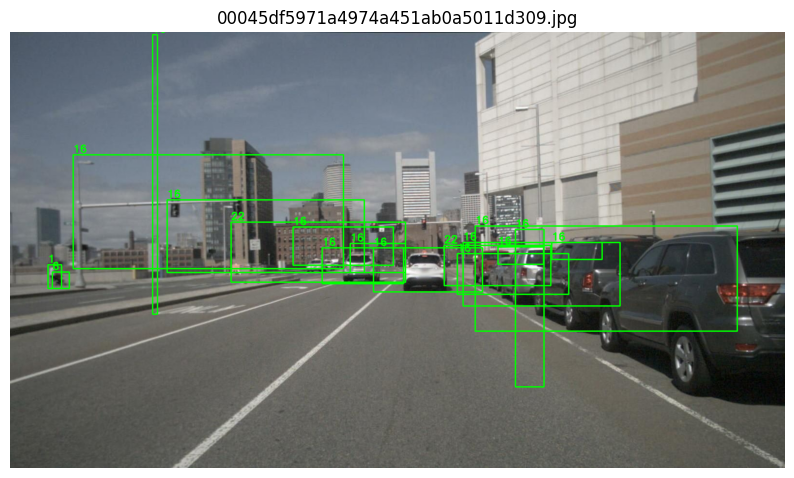

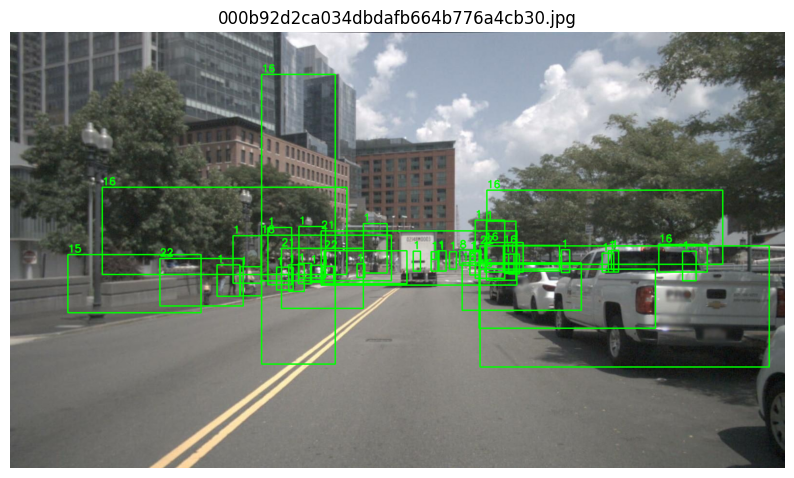

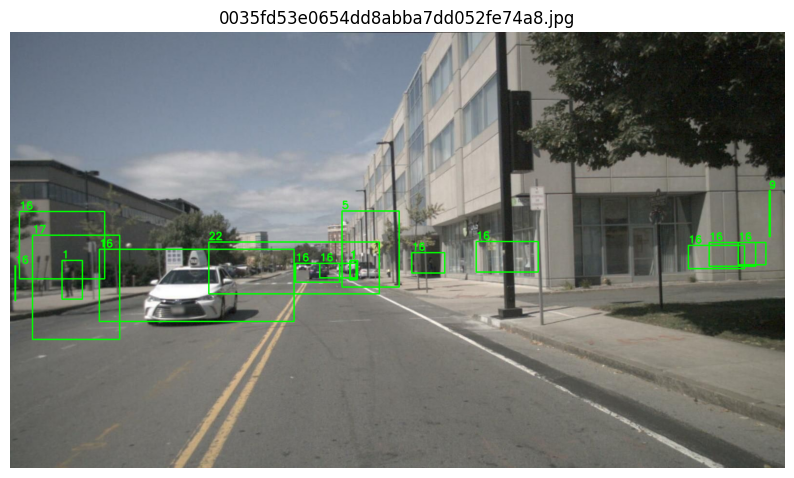

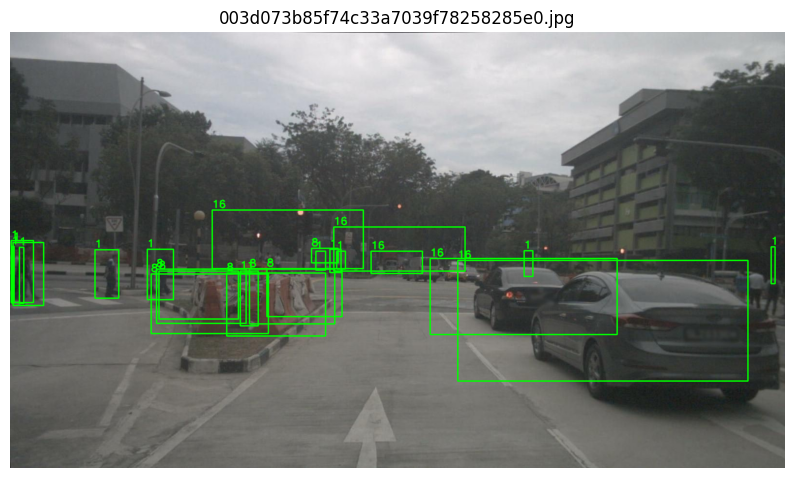

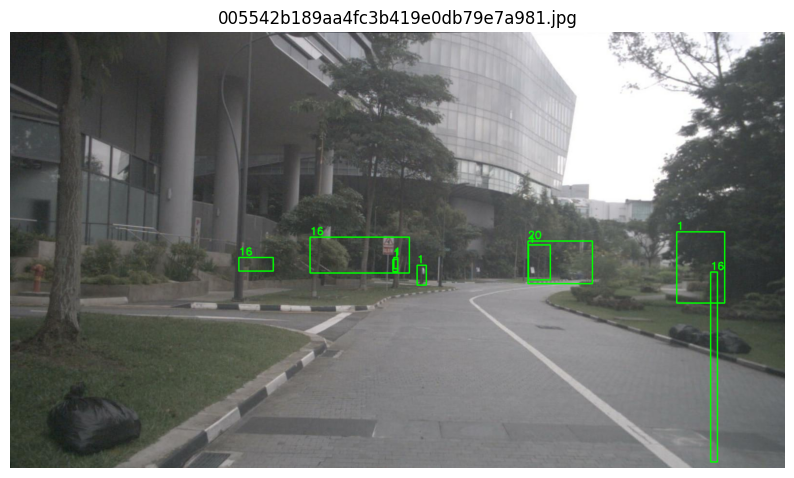

In [19]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory paths
image_dir = '/home/mostafa21314/Extractor/output_yolo_format/images'
label_dir = '/home/mostafa21314/Extractor/output_yolo_format/labels'

# Get a list of image files (limit to 5 for quick visualization)
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])[:5]

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.replace('.jpg', '.txt'))
    
    # Load image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Could not load {img_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # Load labels
    if not os.path.exists(label_path):
        print(f"No label file for {img_file}")
        continue
    with open(label_path) as f:
        for line in f:
            vals = line.strip().split()
            if len(vals) < 5:
                continue
            class_id = int(vals[0])
            x_center, y_center, box_w, box_h = map(float, vals[1:5])
            # Convert normalized to pixel coordinates
            x1 = int((x_center - box_w / 2) * w)
            y1 = int((y_center - box_h / 2) * h)
            x2 = int((x_center + box_w / 2) * w)
            y2 = int((y_center + box_h / 2) * h)
            # Draw rectangle
            color = (0, 255, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, str(class_id), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    
    # Show image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(img_file)
    plt.axis('off')
    plt.show()

In [21]:
import os
label_dir = '/home/mostafa21314/Extractor/output_yolo_format/labels'
for fname in os.listdir(label_dir):
    if fname.endswith('.txt'):
        with open(os.path.join(label_dir, fname)) as f:
            for line in f:
                vals = line.strip().split()
                print(len(vals), vals)
                break  # just check the first line of each file
        break  # just check the first file

11 ['21', '0.406112', '0.549554', '0.142474', '0.202415', '25.846', '-2.987', '849.760', '1364.073', '825.743', '1373.616']
